In [1]:
import numpy as np 
import pandas as pd
from tensorflow import keras
import matplotlib.pyplot as plt 
from PIL import Image
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
import os
import shutil
from tensorflow.keras import metrics
import matplotlib
#from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.optimizers import SGD, RMSprop
plt.style.use('seaborn')


# Create X and y Data: Helper Functions

* create_X_and_y()

In [2]:
def create_X_and_y(X_filepath, y_filepath):
    
    ''' imports lined images and unlined images from jpeg files 
    into numpy arrays for use into autoencoder'''
    
    y_list = []
    for image in sorted(os.listdir(y_filepath)):
        file= y_filepath + str(image)
        y_image = np.array(Image.open(file))
        y_image = y_image.reshape(*y_image.shape,1)
        y_list.append(y_image)
                    
    y = np.array(y_list)  

    X_list = []
    for image in sorted(os.listdir(X_filepath)):
        file = X_filepath+str(image)
        X_image = np.array(Image.open(file))
        X_image = X_image.reshape(*X_image.shape,1)
        X_list.append(X_image)
        
    X = np.array(X_list)
    
    return X,y

In [3]:
'''Create the data X,y '''
y_filepath = 'Data/y_variables/Unruled/'
X_filepath = 'Data/X_variables/computer_generated_lines/'

X,y = create_X_and_y(X_filepath, y_filepath)
X.shape, y.shape

((669, 500, 400, 1), (669, 500, 400, 1))

# Model Setup: Helper Functions
* model:
    create_and_compile()
    fit_model()
    predict()
    
* plot:
    plot_loss()
    plot_accuracy()


In [4]:
def callbacks(model_name = 'model', early_stopping = False, patience = None):
    checkpoint_filepath = (f'./tmp/{model_name}/checkpoint')
    tensorboard = TensorBoard(log_dir=(f"./logs/{model_name}"),
                            
                            histogram_freq=2,
                            write_graph=True,
                            write_images=True,
                            update_freq="epoch",
                            profile_batch=2,
                            embeddings_freq=0,
                            embeddings_metadata=None)
    if early_stopping == True:
        early_stopping = EarlyStopping(monitor='loss',  patience=patience, restore_best_weights=True)
    model_cp = ModelCheckpoint(filepath=checkpoint_filepath, monitor = 'loss', save_best_only=True)
    
    return tensorboard, early_stopping, model_cp



In [5]:
def create_and_compile_sparse_model(optimizer='adam', learning_rate=.001, loss='mse', metrics='accuracy'):
    ''' creates and compiles model '''
    
    input_img = Input(shape=(500,400,1)) 
    x = Conv2D(32, (3, 3), activation='relu')(input_img)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = Dense(128)(x) 
    x= Conv2DTranspose(32,(3,3), activation='relu')(x)
    decoded = Conv2DTranspose(1, (3, 3), activation='linear', padding='same')(x)

    compile_optimizer = Adam(learning_rate=learning_rate)#if ever use different than Adam will need to change this line
    autoencoder = Model(input_img, decoded)
    autoencoder.summary()
    autoencoder.compile(optimizer=compile_optimizer, loss=loss, metrics=metrics)
    return autoencoder

In [6]:
def sequential_model(loss = 'mse', optimizer = 'adam', metrics=['accuracy']):
    '''creates and compiles a simple Sequential Model.'''
    
    model = Sequential()
    model.add(Input(shape=(500,400,1)))
  
    model.add(Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'))
    model.add(Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'))
    model.add(Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'))

    model.add(Dense(128,  activation='relu'))
    model.add(Dense(2,    activation='linear', name="bottleneck"))
    model.add(Dense(128,  activation='relu'))

    model.add(Conv2DTranspose(filters = 32, kernel_size=(3,3), activation='relu'))
    model.add(Conv2DTranspose(filters = 32, kernel_size=(3,3), activation='relu'))
    model.add(Conv2DTranspose(filters = 32, kernel_size=(3,3), activation='relu'))
    model.add(Conv2DTranspose(filters = 1, kernel_size=(3,3), activation='linear', padding='same'))

    model.summary()
    
    model.compile(loss = loss, optimizer = optimizer, metrics=metrics) 
    #does Saquential have a compile optimizer?
    return model




In [7]:
def fit_model(compiled_model, x=X, y=y, batch_size=15, epochs=50, verbose=1, callbacks=None, validation_split=0.2):

    history = compiled_model.fit(x=X, y=y, batch_size=batch_size, epochs = epochs, verbose=verbose, callbacks=callbacks, validation_split=validation_split)
    return history

In [8]:
def plot_loss(model_name, model_history, metric_1 = 'loss', color_1='blue', metric_1_label = 'Training Loss Score by Epoch', 
                 metric_2 = 'val_loss', color_2='green', metric_2_label = 'Validation Loss Score by Epoch'):
    
    plt.plot(model_history.history[metric_1], color=color_1, label=metric_1_label)
    plt.plot(model_history.history[metric_2], color=color_2, label=metric_2_label)
    plt.title(label=model_name)
    plt.legend()


In [9]:
def plot_accuracy(model_name, model_history, metric_3 = 'accuracy', color_3='red', metric_3_label = 'Training Accuracy Score by Epoch', 
                 metric_4 = 'val_accuracy', color_4='orange', metric_4_label = 'Validation Accuracy Score by Epoch'):
    
    plt.plot(model_history.history[metric_3], color=color_3, label=metric_3_label)
    plt.plot(model_history.history[metric_4], color=color_4, label=metric_4_label)
    plt.title(label=model_name)
    plt.legend()

In [10]:
def predict_image_on_X(fitted_model, X=X, index=0):
    result = fitted_model.predict(X)
    result[result>255]=255
    result[result<0] = 0
    result = result[index].astype(np.uint8).reshape(500,400)
    original = X[index].astype(np.uint8).reshape(500,400)
    
    return Image.fromarray(np.hstack([original, result]))

In [11]:
def predict_on_unseen(fitted_model, file_path_list):
    
    '''Removes the lines on images that the model has NOT seen. To see the images index into list that is returned.''' 
    
    
    if len(file_path_list)== 1:
        image_to_predict = np.array(Image.open(str(file_path_list)))
        result = fitted_model.predict(np.array([image_to_predict.reshape(*image_to_predict.shape, 1)]))
        result[result>255]=255
        result[result<0] = 0
        result = result.astype(np.uint8).reshape(500,400)
        return Image.fromarray(np.hstack([image_to_predict, result]))
                                    
    else:
        original_image_list = []
        result_image_list = []
        difference_list = []
        for idx, original_image in enumerate(file_path_list):
            original_image = np.array(Image.open(str(file_path_list[idx])))
            original_image_list.append(original_image)
                                      
            result = fitted_model.predict(np.array([original_image.reshape(*original_image.shape, 1)]))
            result[result>255]=255
            result[result<0] = 0
            result = result.astype(np.uint8).reshape(500,400)
            result_image_list.append(result)
            difference_list.append(result - original_image)
        all_results_list=[]
        for idx, images in enumerate(zip(original_image_list, result_image_list, difference_list)):
            all_results_list.append(Image.fromarray(np.hstack([original_image_list[idx], result_image_list[idx], difference_list[idx]])))
        return all_results_list


In [12]:
def open_saved_model(model_name):
    model = load_model(f'./tmp/{model_name}/checkpoint', custom_objects=None,
                       compile=True, options=None)
    return model
                       
                       
    #/home/ubuntu/Capstone_3/tmp/checkpoint/saved_model.pb
    #full filepath as an example

# The Models w/ Results

### Model Type 1: Sparse


In [44]:
#set up model callbacks
tensorboard, early_stopping, model_cp = callbacks(model_name = 'sparse_2', 
                                                  early_stopping = True, patience = 15)

#create and compile model
sparse_2 = create_and_compile_sparse_model(optimizer='adam', learning_rate=.0001, 
                                           loss='mse', metrics='accuracy')

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 500, 400, 1)]     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 498, 398, 32)      320       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 498, 398, 8)       2312      
_________________________________________________________________
dense_1 (Dense)              (None, 498, 398, 128)     1152      
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 500, 400, 32)      36896     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 500, 400, 1)       289       
Total params: 40,969
Trainable params: 40,969
Non-trainable params: 0
__________________________________________________

In [45]:
sparse_2_history = fit_model(sparse_2, x=X, y=y, batch_size=15, epochs=5000, 
                             verbose=1, callbacks=[tensorboard,early_stopping,model_cp], 
                             validation_split=0.2)




Epoch 1/5000
 1/36 [..............................] - ETA: 0s - loss: 70692.5000 - accuracy: 3.3333e-07WARNING:tensorflow:From /home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/gpu/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
36/36 [==============================] - ETA: 0s - loss: 38323.5508 - accuracy: 3.6598e-05WARNING:tensorflow:From /home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/gpu/lib/python3.7/site-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as upda

36/36 [==============================] - 5s 128ms/step - loss: 62.5683 - accuracy: 5.4953e-06 - val_loss: 63.4774 - val_accuracy: 1.2127e-05
Epoch 23/5000
36/36 [==============================] - 5s 129ms/step - loss: 57.9823 - accuracy: 5.5701e-06 - val_loss: 58.8447 - val_accuracy: 1.2276e-05
Epoch 24/5000
36/36 [==============================] - 5s 133ms/step - loss: 54.0537 - accuracy: 5.8692e-06 - val_loss: 55.1858 - val_accuracy: 1.2500e-05
Epoch 25/5000
36/36 [==============================] - 5s 129ms/step - loss: 50.7965 - accuracy: 5.9439e-06 - val_loss: 52.2447 - val_accuracy: 1.2910e-05
Epoch 26/5000
36/36 [==============================] - 5s 128ms/step - loss: 48.1044 - accuracy: 6.1402e-06 - val_loss: 49.6008 - val_accuracy: 1.3209e-05
Epoch 27/5000
36/36 [==============================] - 5s 129ms/step - loss: 45.6377 - accuracy: 6.4206e-06 - val_loss: 46.9205 - val_accuracy: 1.8396e-05
Epoch 28/5000
36/36 [==============================] - 5s 128ms/step - loss: 43.1258

Epoch 49/5000
36/36 [==============================] - 5s 133ms/step - loss: 20.6260 - accuracy: 9.8785e-06 - val_loss: 22.0536 - val_accuracy: 1.8843e-05
Epoch 50/5000
36/36 [==============================] - 5s 130ms/step - loss: 20.3283 - accuracy: 9.8037e-06 - val_loss: 21.9275 - val_accuracy: 1.9552e-05
Epoch 51/5000
36/36 [==============================] - 5s 130ms/step - loss: 20.0522 - accuracy: 1.0514e-05 - val_loss: 21.3973 - val_accuracy: 1.8470e-05
Epoch 52/5000
36/36 [==============================] - 5s 130ms/step - loss: 19.7766 - accuracy: 9.8879e-06 - val_loss: 21.1054 - val_accuracy: 1.8731e-05
Epoch 53/5000
36/36 [==============================] - 5s 129ms/step - loss: 19.5297 - accuracy: 9.5327e-06 - val_loss: 21.1225 - val_accuracy: 1.8545e-05
Epoch 54/5000
36/36 [==============================] - 5s 128ms/step - loss: 19.3163 - accuracy: 9.3364e-06 - val_loss: 20.9443 - val_accuracy: 1.8843e-05
Epoch 55/5000
36/36 [==============================] - 5s 134ms/step -

Epoch 76/5000
36/36 [==============================] - 5s 130ms/step - loss: 16.6889 - accuracy: 7.9159e-06 - val_loss: 18.2010 - val_accuracy: 1.7201e-05
Epoch 77/5000
36/36 [==============================] - 5s 133ms/step - loss: 16.6514 - accuracy: 7.8131e-06 - val_loss: 18.0381 - val_accuracy: 1.7052e-05
Epoch 78/5000
36/36 [==============================] - 5s 129ms/step - loss: 16.5562 - accuracy: 8.1308e-06 - val_loss: 17.8487 - val_accuracy: 1.6903e-05
Epoch 79/5000
36/36 [==============================] - 5s 130ms/step - loss: 16.4851 - accuracy: 7.2617e-06 - val_loss: 18.3193 - val_accuracy: 1.8097e-05
Epoch 80/5000
36/36 [==============================] - 4s 104ms/step - loss: 16.5035 - accuracy: 7.9626e-06 - val_loss: 17.8218 - val_accuracy: 1.7201e-05
Epoch 81/5000
36/36 [==============================] - 5s 129ms/step - loss: 16.4817 - accuracy: 7.4673e-06 - val_loss: 17.7077 - val_accuracy: 1.8060e-05
Epoch 82/5000
36/36 [==============================] - 5s 130ms/step -

36/36 [==============================] - 5s 129ms/step - loss: 15.1134 - accuracy: 7.7103e-06 - val_loss: 16.4705 - val_accuracy: 1.7612e-05
Epoch 107/5000
36/36 [==============================] - 5s 130ms/step - loss: 15.0325 - accuracy: 7.5234e-06 - val_loss: 16.3767 - val_accuracy: 1.7687e-05
Epoch 108/5000
36/36 [==============================] - 4s 105ms/step - loss: 15.2158 - accuracy: 7.6355e-06 - val_loss: 17.0849 - val_accuracy: 1.9925e-05
Epoch 109/5000
36/36 [==============================] - 4s 105ms/step - loss: 15.0659 - accuracy: 7.4860e-06 - val_loss: 16.4004 - val_accuracy: 1.7724e-05
Epoch 110/5000
36/36 [==============================] - 5s 129ms/step - loss: 14.9051 - accuracy: 7.8224e-06 - val_loss: 16.2729 - val_accuracy: 1.7948e-05
Epoch 111/5000
36/36 [==============================] - 5s 129ms/step - loss: 14.8713 - accuracy: 7.4299e-06 - val_loss: 16.5231 - val_accuracy: 1.7201e-05
Epoch 112/5000
36/36 [==============================] - 4s 104ms/step - loss: 1

Epoch 141/5000
36/36 [==============================] - 5s 130ms/step - loss: 13.9058 - accuracy: 7.0935e-06 - val_loss: 15.2435 - val_accuracy: 1.6343e-05
Epoch 142/5000
36/36 [==============================] - 5s 130ms/step - loss: 13.8871 - accuracy: 7.1589e-06 - val_loss: 15.4710 - val_accuracy: 1.5970e-05
Epoch 143/5000
36/36 [==============================] - 4s 105ms/step - loss: 13.9933 - accuracy: 6.9346e-06 - val_loss: 15.4644 - val_accuracy: 1.6567e-05
Epoch 144/5000
36/36 [==============================] - 4s 105ms/step - loss: 13.9534 - accuracy: 7.2243e-06 - val_loss: 15.2066 - val_accuracy: 1.6493e-05
Epoch 145/5000
36/36 [==============================] - 4s 105ms/step - loss: 13.9121 - accuracy: 6.7757e-06 - val_loss: 15.2968 - val_accuracy: 1.6604e-05
Epoch 146/5000
36/36 [==============================] - 4s 105ms/step - loss: 13.9915 - accuracy: 6.8037e-06 - val_loss: 15.7520 - val_accuracy: 1.8731e-05
Epoch 147/5000
36/36 [==============================] - 4s 105ms

Epoch 179/5000
36/36 [==============================] - 5s 130ms/step - loss: 13.1219 - accuracy: 6.9346e-06 - val_loss: 14.4875 - val_accuracy: 1.5261e-05
Epoch 180/5000
36/36 [==============================] - 5s 129ms/step - loss: 13.0989 - accuracy: 6.7664e-06 - val_loss: 14.6102 - val_accuracy: 1.5970e-05
Epoch 181/5000
36/36 [==============================] - 5s 129ms/step - loss: 13.0299 - accuracy: 6.6729e-06 - val_loss: 14.3674 - val_accuracy: 1.6082e-05
Epoch 182/5000
36/36 [==============================] - 4s 105ms/step - loss: 13.0971 - accuracy: 6.5794e-06 - val_loss: 14.3345 - val_accuracy: 1.6903e-05
Epoch 183/5000
36/36 [==============================] - 4s 105ms/step - loss: 13.1667 - accuracy: 6.7477e-06 - val_loss: 14.9868 - val_accuracy: 1.5672e-05
Epoch 184/5000
36/36 [==============================] - 4s 105ms/step - loss: 13.1042 - accuracy: 6.8692e-06 - val_loss: 14.2544 - val_accuracy: 1.6903e-05
Epoch 185/5000
36/36 [==============================] - 4s 105ms

Epoch 257/5000
36/36 [==============================] - 5s 129ms/step - loss: 11.8684 - accuracy: 9.0374e-06 - val_loss: 13.0949 - val_accuracy: 2.3955e-05
Epoch 258/5000
36/36 [==============================] - 5s 130ms/step - loss: 11.8075 - accuracy: 1.0570e-05 - val_loss: 13.0922 - val_accuracy: 2.2575e-05
Epoch 259/5000
36/36 [==============================] - 4s 105ms/step - loss: 11.9603 - accuracy: 9.0000e-06 - val_loss: 13.2067 - val_accuracy: 2.3694e-05
Epoch 260/5000
36/36 [==============================] - 4s 105ms/step - loss: 12.1922 - accuracy: 1.0907e-05 - val_loss: 13.3798 - val_accuracy: 2.3396e-05
Epoch 261/5000
36/36 [==============================] - 4s 105ms/step - loss: 12.3036 - accuracy: 1.0103e-05 - val_loss: 13.4247 - val_accuracy: 2.2948e-05
Epoch 262/5000
36/36 [==============================] - 4s 105ms/step - loss: 12.0683 - accuracy: 9.5140e-06 - val_loss: 13.1734 - val_accuracy: 2.4776e-05
Epoch 263/5000
36/36 [==============================] - 4s 105ms

Epoch 339/5000
36/36 [==============================] - 4s 105ms/step - loss: 11.2233 - accuracy: 1.1505e-05 - val_loss: 14.3759 - val_accuracy: 3.2090e-05
Epoch 340/5000
36/36 [==============================] - 4s 105ms/step - loss: 11.2702 - accuracy: 1.4869e-05 - val_loss: 12.3048 - val_accuracy: 2.7351e-05
Epoch 341/5000
36/36 [==============================] - 5s 134ms/step - loss: 10.9729 - accuracy: 1.2720e-05 - val_loss: 12.3596 - val_accuracy: 2.8321e-05
Epoch 342/5000
36/36 [==============================] - 4s 104ms/step - loss: 11.0455 - accuracy: 1.3215e-05 - val_loss: 12.2680 - val_accuracy: 2.9142e-05
Epoch 343/5000
36/36 [==============================] - 5s 130ms/step - loss: 10.9585 - accuracy: 1.1841e-05 - val_loss: 12.1759 - val_accuracy: 3.0970e-05
Epoch 344/5000
36/36 [==============================] - 4s 105ms/step - loss: 11.1376 - accuracy: 1.3168e-05 - val_loss: 12.3481 - val_accuracy: 2.9664e-05
Epoch 345/5000
36/36 [==============================] - 4s 105ms

Epoch 426/5000
36/36 [==============================] - 4s 105ms/step - loss: 10.3312 - accuracy: 1.4196e-05 - val_loss: 11.4087 - val_accuracy: 3.3284e-05
Epoch 427/5000
36/36 [==============================] - 4s 105ms/step - loss: 10.2266 - accuracy: 1.4785e-05 - val_loss: 11.7514 - val_accuracy: 3.1716e-05
Epoch 428/5000
36/36 [==============================] - 4s 105ms/step - loss: 10.1874 - accuracy: 1.5467e-05 - val_loss: 11.5034 - val_accuracy: 3.3433e-05
Epoch 429/5000
36/36 [==============================] - 4s 105ms/step - loss: 10.4636 - accuracy: 1.3654e-05 - val_loss: 11.6545 - val_accuracy: 3.5485e-05
Epoch 430/5000
36/36 [==============================] - 4s 105ms/step - loss: 10.2642 - accuracy: 1.5168e-05 - val_loss: 11.5196 - val_accuracy: 3.2239e-05
Epoch 431/5000
36/36 [==============================] - 4s 105ms/step - loss: 10.1838 - accuracy: 1.4196e-05 - val_loss: 11.5605 - val_accuracy: 3.7015e-05
Epoch 432/5000
36/36 [==============================] - 4s 104ms

Epoch 516/5000
36/36 [==============================] - 4s 105ms/step - loss: 9.6527 - accuracy: 1.5963e-05 - val_loss: 10.8882 - val_accuracy: 3.2575e-05
Epoch 517/5000
36/36 [==============================] - 5s 129ms/step - loss: 9.5587 - accuracy: 1.4813e-05 - val_loss: 10.8367 - val_accuracy: 3.8470e-05
Epoch 518/5000
36/36 [==============================] - 4s 105ms/step - loss: 9.6017 - accuracy: 1.5215e-05 - val_loss: 10.8634 - val_accuracy: 3.7948e-05
Epoch 519/5000
36/36 [==============================] - 4s 105ms/step - loss: 9.5631 - accuracy: 1.5065e-05 - val_loss: 10.7937 - val_accuracy: 3.6343e-05
Epoch 520/5000
36/36 [==============================] - 4s 105ms/step - loss: 10.1029 - accuracy: 1.5888e-05 - val_loss: 13.1453 - val_accuracy: 3.6866e-05
Epoch 521/5000
36/36 [==============================] - 4s 105ms/step - loss: 9.7316 - accuracy: 1.6879e-05 - val_loss: 11.0412 - val_accuracy: 3.3993e-05
Epoch 522/5000
36/36 [==============================] - 4s 106ms/step

Epoch 562/5000
36/36 [==============================] - 4s 105ms/step - loss: 9.3931 - accuracy: 1.6495e-05 - val_loss: 10.5809 - val_accuracy: 3.7276e-05
Epoch 563/5000
36/36 [==============================] - 4s 105ms/step - loss: 9.6204 - accuracy: 1.6037e-05 - val_loss: 11.0459 - val_accuracy: 3.7537e-05
Epoch 564/5000
36/36 [==============================] - 4s 105ms/step - loss: 9.4044 - accuracy: 1.5393e-05 - val_loss: 10.6083 - val_accuracy: 3.7836e-05
Epoch 565/5000
36/36 [==============================] - 4s 105ms/step - loss: 9.5813 - accuracy: 1.6523e-05 - val_loss: 11.1168 - val_accuracy: 3.6940e-05
Epoch 566/5000
36/36 [==============================] - 4s 105ms/step - loss: 9.4448 - accuracy: 1.5832e-05 - val_loss: 10.8125 - val_accuracy: 3.8955e-05
Epoch 567/5000
36/36 [==============================] - 4s 105ms/step - loss: 9.3941 - accuracy: 1.5168e-05 - val_loss: 10.7228 - val_accuracy: 3.6642e-05
Epoch 568/5000
36/36 [==============================] - 4s 105ms/step 

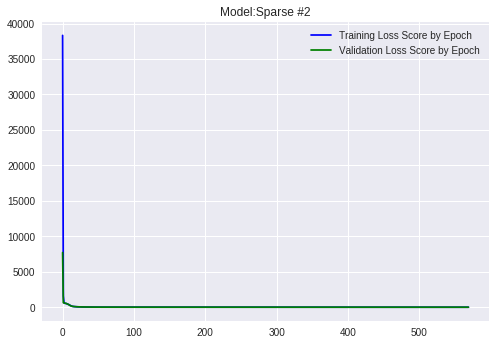

In [46]:
name = 'Model:Sparse #2'
history = sparse_2_history
plot_loss(name, history)

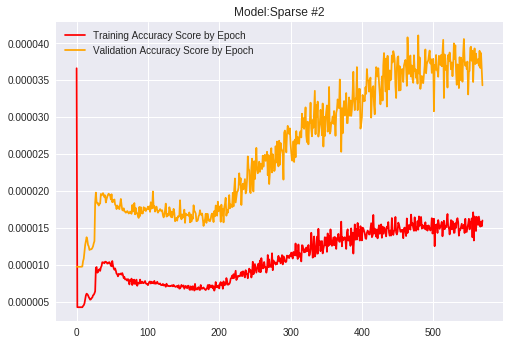

In [47]:
plot_accuracy(name, history)

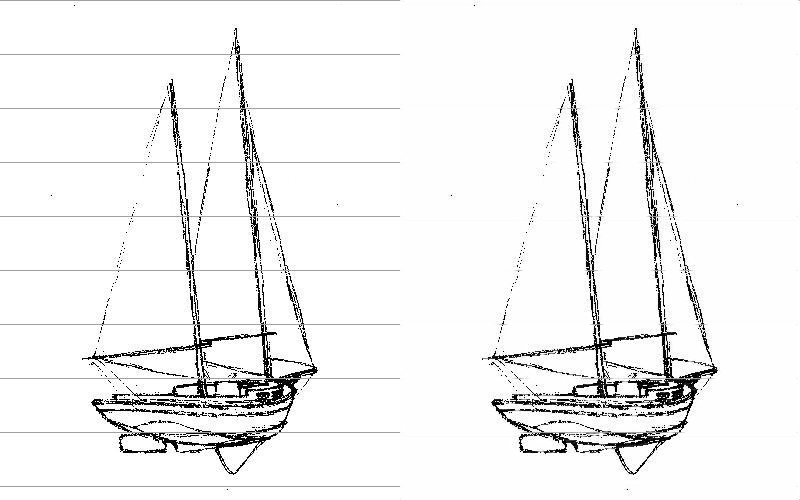

In [48]:
predict_image_on_X(sparse_2)


In [49]:
file_paths = ['Data/Original_Ruled/IMG_0003.jpg', 'Data/Original_Ruled/IMG_0005.jpg',
              'Data/Original_Ruled/IMG_0008.jpg','Data/Original_Ruled/IMG_0012.jpg',
              'Data/Original_Ruled/IMG_0035.jpg','Data/Original_Ruled/IMG_0042.jpg',
              'Data/Original_Ruled/IMG_0045.jpg','Data/Original_Ruled/IMG_0296.jpg',
              'Data/Original_Ruled/Sketch60s_0095.jpg']
#file_path = 'Data/Original_Ruled/IMG_0003.jpg'
unseen = predict_on_unseen(sparse_2, file_paths)

len(unseen)

9

In [50]:
#unseen[0]

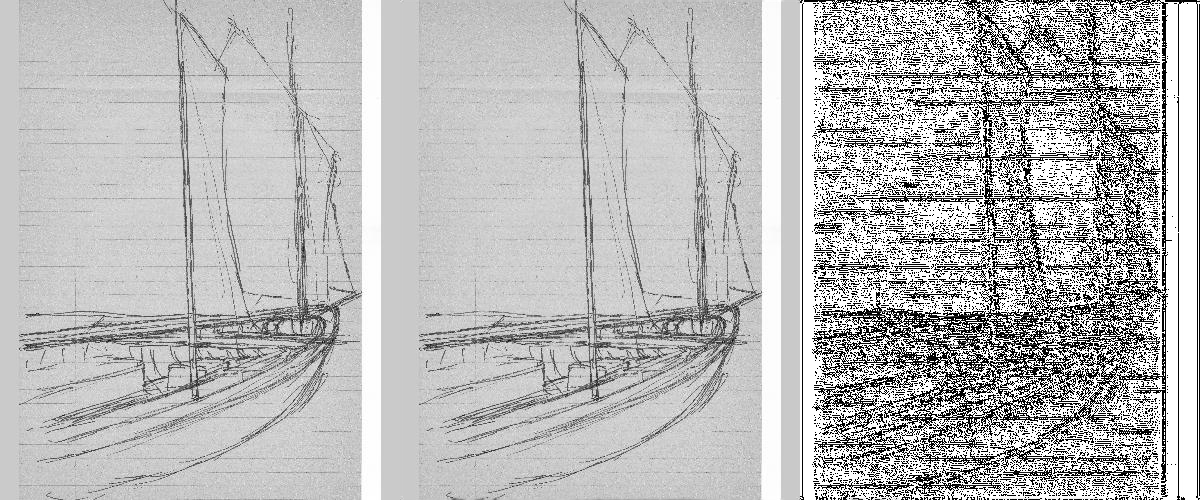

In [51]:
unseen[1]

In [52]:
#unseen[2]

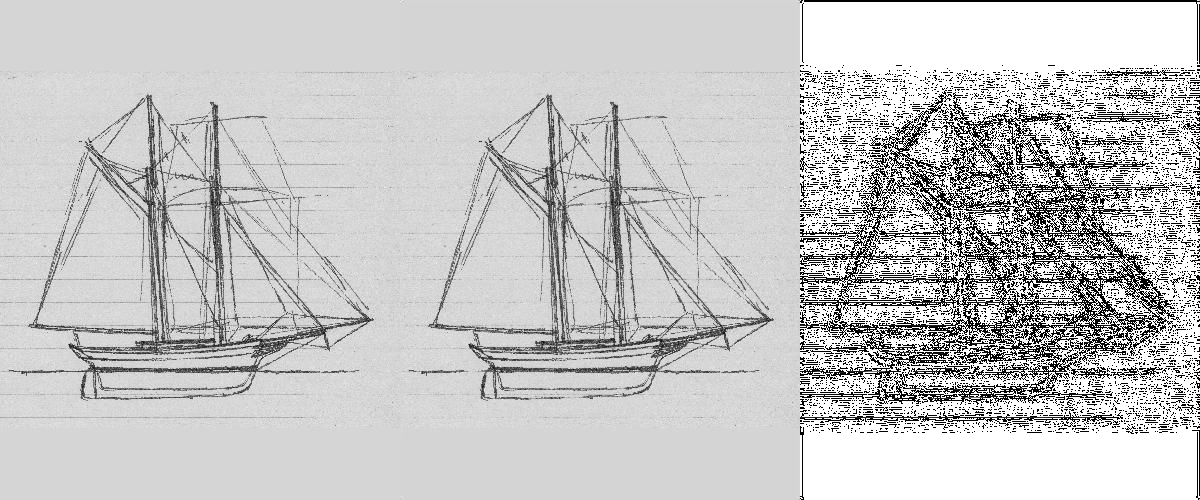

In [53]:
unseen[3]

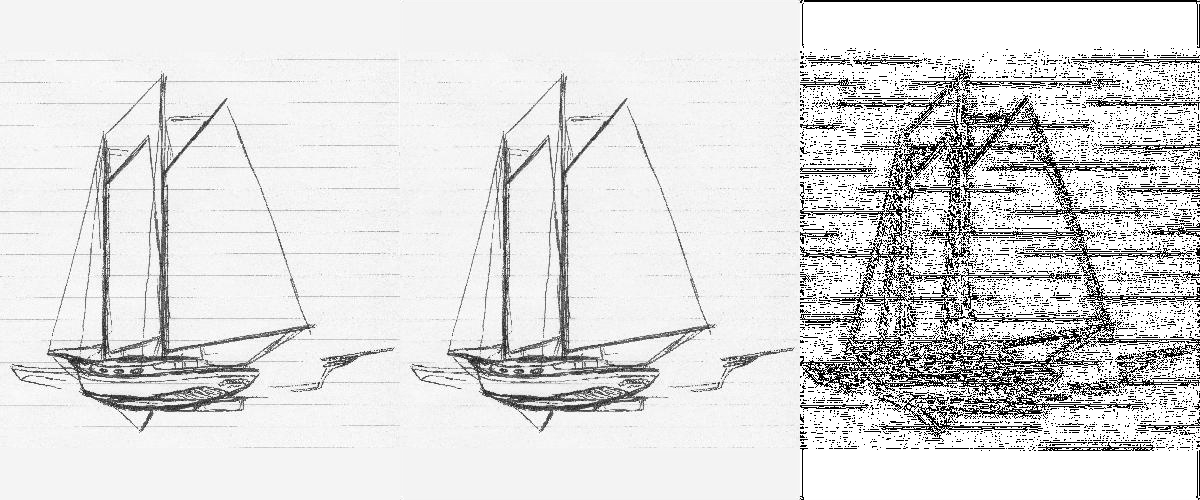

In [54]:
unseen[4]

In [55]:
#unseen[5]

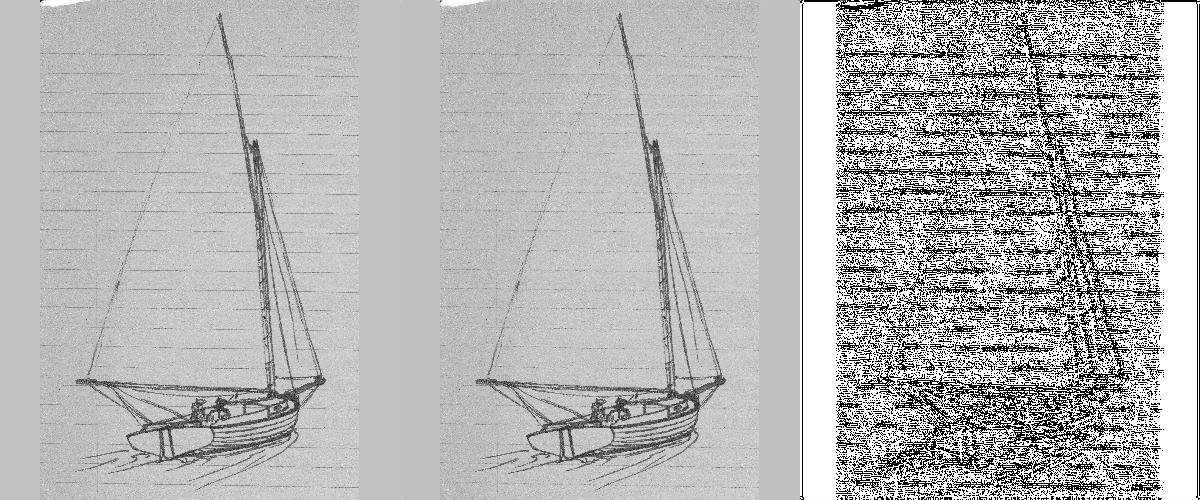

In [56]:
unseen[6]

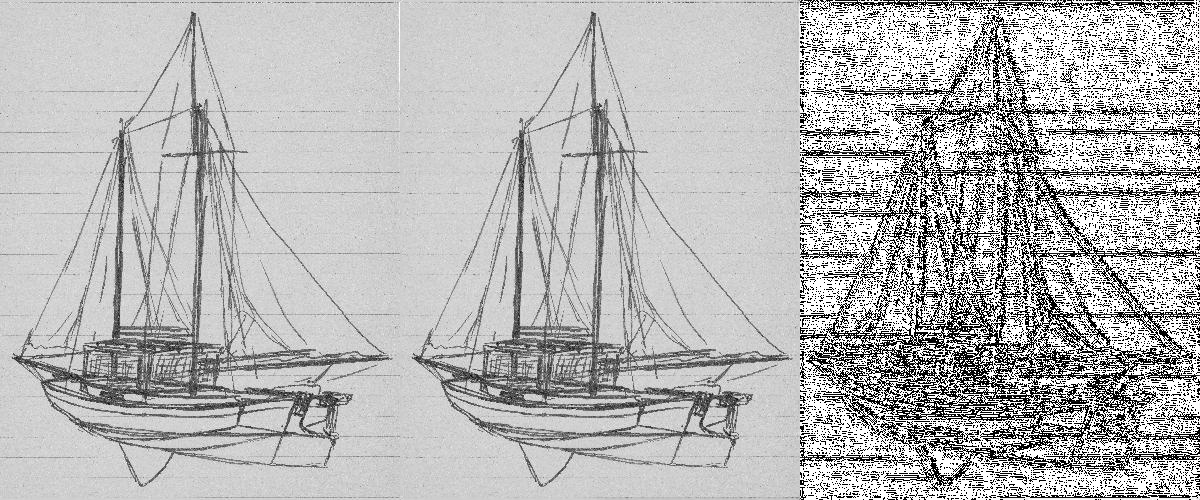

In [57]:
unseen[7]# next try - save this 'enhanced' figure - then apply this model to the enhanced figure - see results

Question for Land - or anyone - how do i get score for (# of same value of pixels/total value of pixels) = difference in pixel colors: image 1(ex. (pixel color = range (0-256)) v pixel location

## Model Type 2: Sequential

In [ ]:
#set up model callbacks
tensorboard, early_stopping, model_cp = callbacks(model_name = 'Sequential_2', 
                                                  early_stopping = True, patience = 20)

#create and compile model
Sequential_2 = sequential_model(loss = 'mse', optimizer = 'adam',
                                metrics=['accuracy'])

In [ ]:
Sequential_2_history = fit_model(Sequential_2, x=X, y=y, batch_size=15, epochs=5000, verbose=1, 
                             callbacks=[tensorboard, early_stopping, model_cp], 
                             validation_split=0.2)

Epoch 1/5000
36/36 [==============================] - 8s 236ms/step - loss: 13.4126 - accuracy: 1.6299e-05 - val_loss: 13.8976 - val_accuracy: 2.6791e-05
Epoch 2/5000
36/36 [==============================] - 8s 234ms/step - loss: 13.5426 - accuracy: 1.3252e-05 - val_loss: 14.7278 - val_accuracy: 3.2090e-05
Epoch 3/5000
36/36 [==============================] - 10s 285ms/step - loss: 13.2634 - accuracy: 1.4981e-05 - val_loss: 13.3628 - val_accuracy: 3.7500e-05
Epoch 4/5000
36/36 [==============================] - 8s 234ms/step - loss: 14.0801 - accuracy: 1.7449e-05 - val_loss: 14.7502 - val_accuracy: 3.0112e-05
Epoch 5/5000
36/36 [==============================] - 8s 235ms/step - loss: 13.5281 - accuracy: 1.0449e-05 - val_loss: 14.2154 - val_accuracy: 4.3284e-05
Epoch 6/5000
36/36 [==============================] - 8s 234ms/step - loss: 14.4741 - accuracy: 2.0701e-05 - val_loss: 13.8140 - val_accuracy: 2.0634e-05
Epoch 7/5000
36/36 [==============================] - 8s 235ms/step - loss:

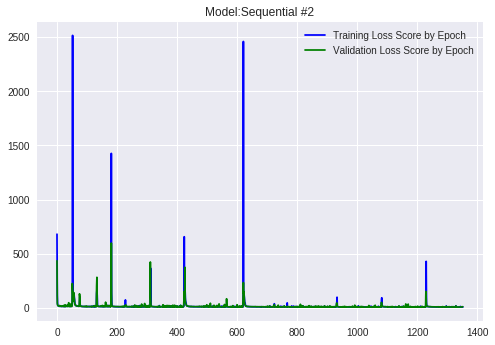

In [80]:
name = 'Model:Sequential #2'
plot_loss(name, Sequential_2_history)

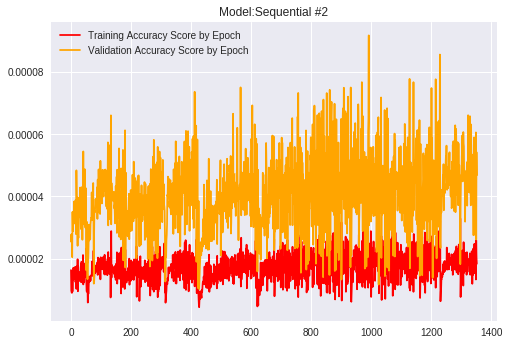

In [81]:
plot_accuracy(name, Sequential_2_history)

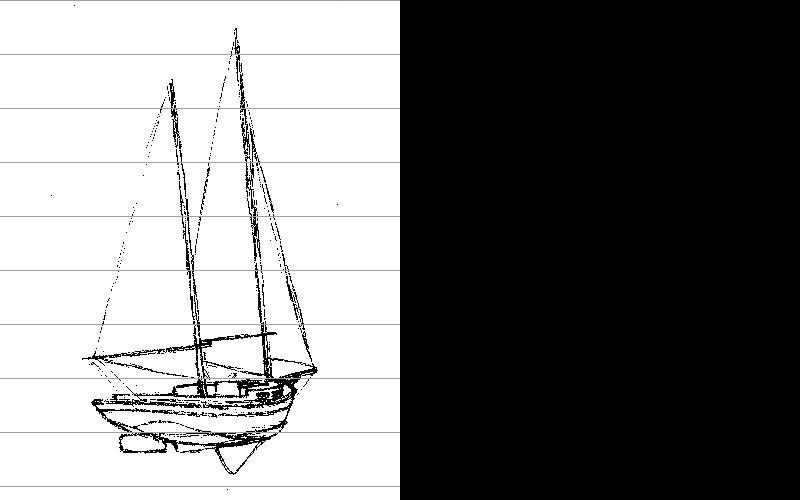

In [82]:
predict_image_on_X(Sequential_2)

In [83]:
file_paths = ['Data/Original_Ruled/IMG_0003.jpg', 'Data/Original_Ruled/IMG_0005.jpg',
              'Data/Original_Ruled/IMG_0008.jpg','Data/Original_Ruled/IMG_0012.jpg',
              'Data/Original_Ruled/IMG_0035.jpg','Data/Original_Ruled/IMG_0042.jpg',
              'Data/Original_Ruled/IMG_0045.jpg','Data/Original_Ruled/IMG_0296.jpg',
              'Data/Original_Ruled/Sketch60s_0095.jpg']
#file_path = 'Data/Original_Ruled/IMG_0003.jpg'
Seq_1_unseen = predict_on_unseen(Sequential_2, file_paths)

len(seq_unseen)

9

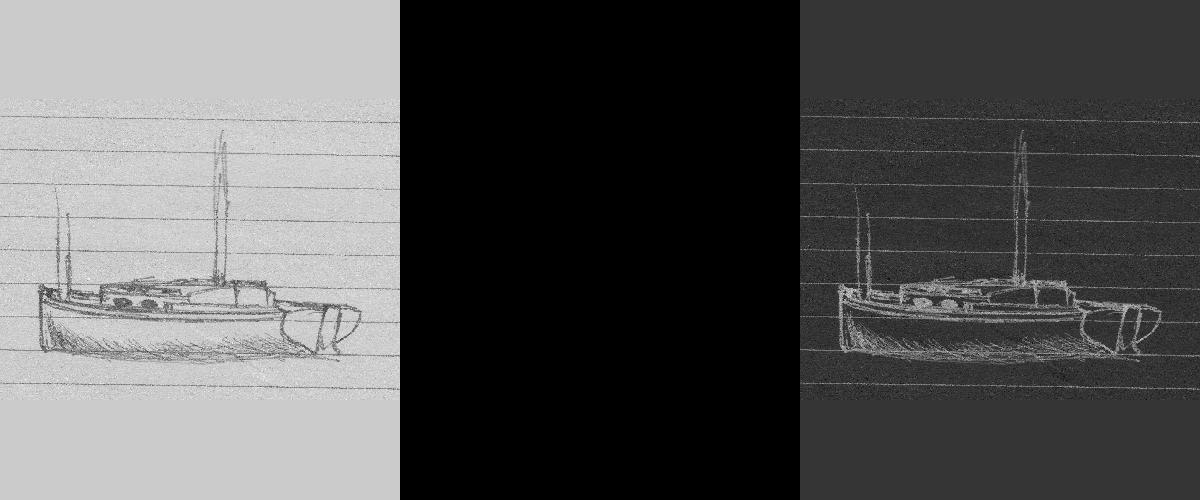

In [84]:
Seq_1_unseen[0]

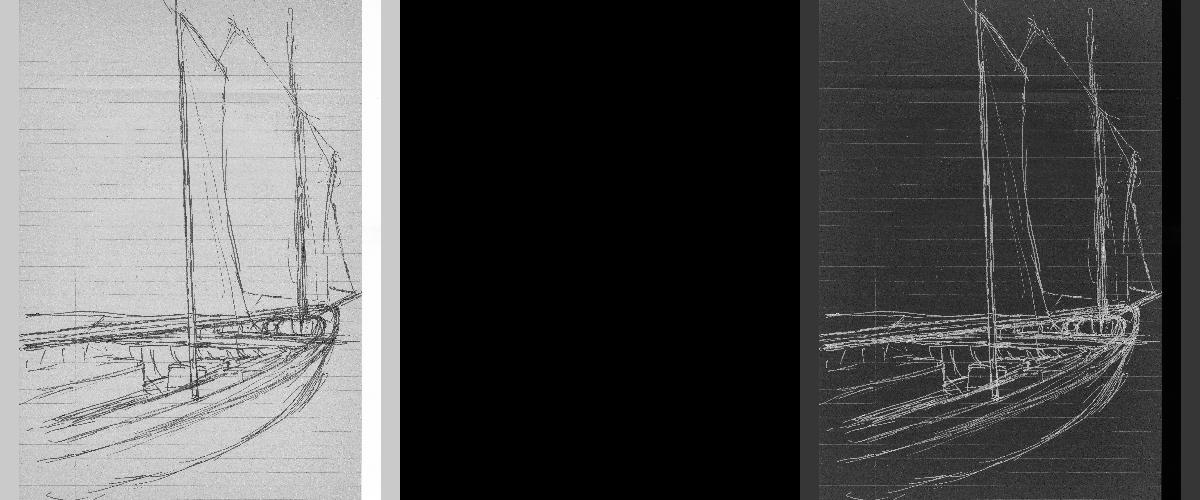

In [85]:
Seq_1_unseen[1]

In [86]:
#Seq_1_unseen[2]

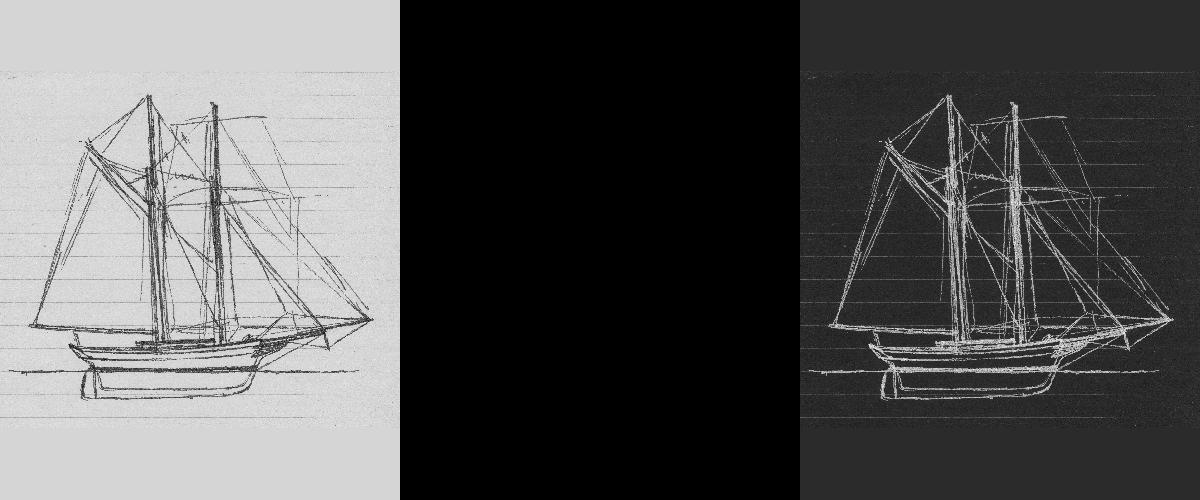

In [87]:
Seq_1_unseen[3]

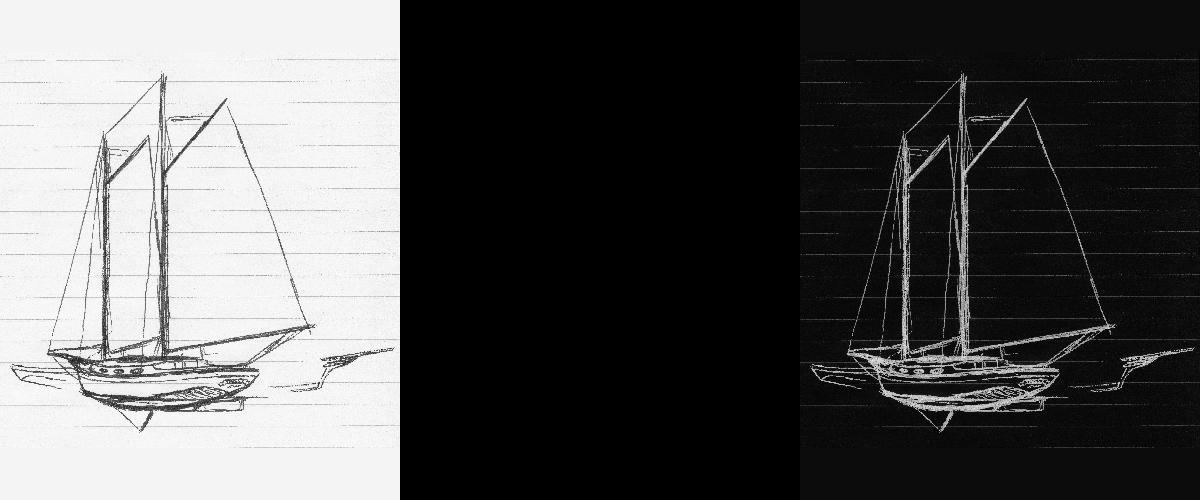

In [88]:
Seq_1_unseen[4]

In [89]:
#Seq_1_unseen[5]

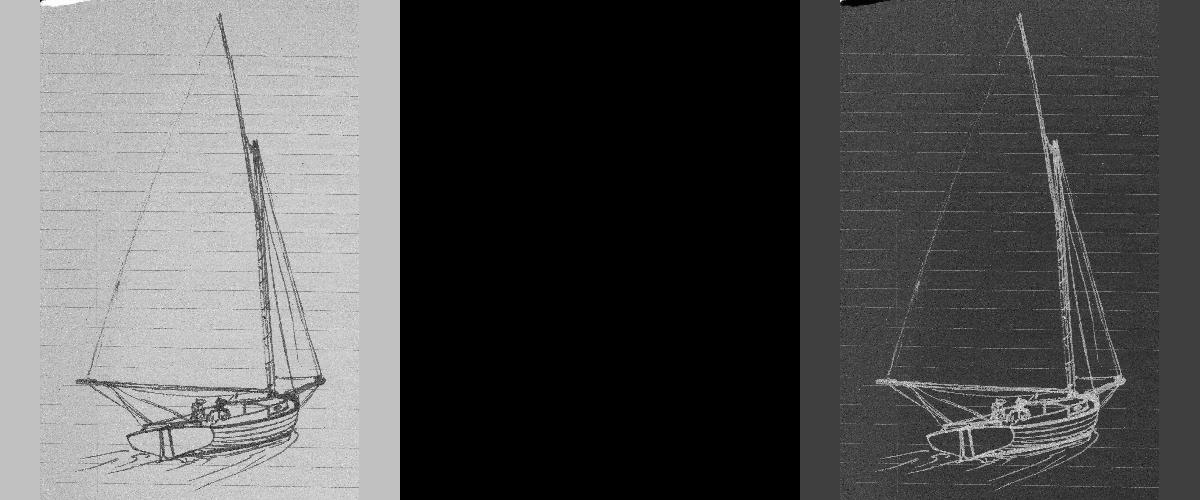

In [90]:
Seq_1_unseen[6]

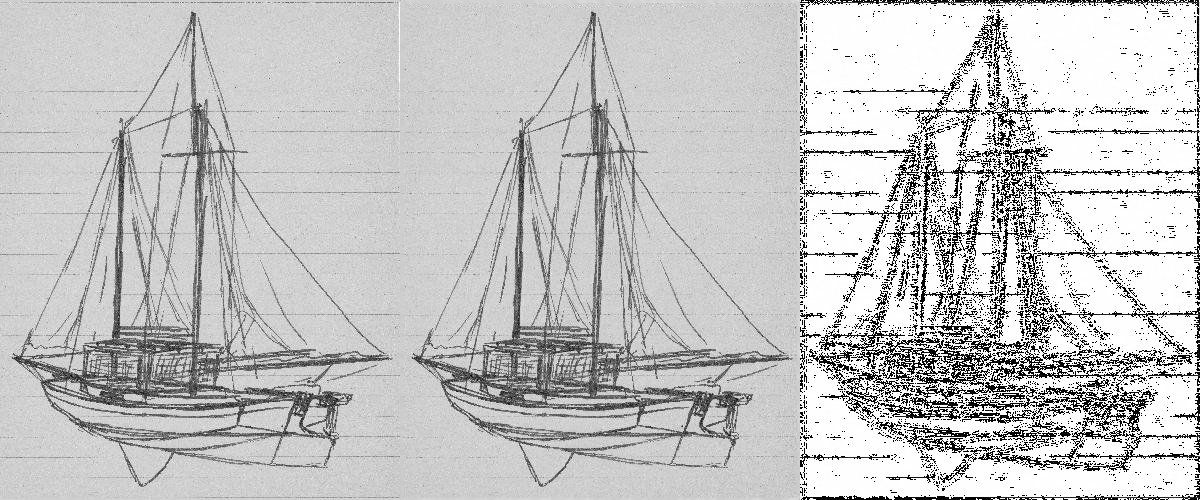

In [56]:
Seq_1_unseen[7]

In [57]:
#Seq_1_unseen[8]

# Evaluate saved models 

In [37]:
# bring back model if lost
# sparse_3 = open_saved_model('sparse_3')


In [43]:
sparse_1 = open_saved_model('sparse_1')
sparse_1.evaluate(X,y, return_dict=True)


21/21 [==============================] - 1s 68ms/step - loss: 8.8567 - accuracy: 1.8827e-05


{'loss': 8.856673240661621, 'accuracy': 1.8826607629307546e-05}

In [13]:
sparse_2 = open_saved_model('sparse_2')
sparse_2.evaluate(X,y, return_dict=True)

InternalError: CUDA runtime implicit initialization on GPU:0 failed. Status: out of memory

JUNK BELOW THIS LINE:

In [ ]:
image_to_predict = np.array(Image.open('Data/Original_Ruled/IMG_0003.jpg'))

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))

ax[0].imshow(scharr)
ax[0].set_title('Scharr')
ax[0].axis('off')

ax[1].imshow(scharr_h)
ax[1].set_title('Scharr Horizontal')
ax[1].axis('off')

ax[2].imshow(scharr_v)
ax[2].set_title('Scharr Vertical')
ax[2].axis('off')
